In [1]:
from tempfile import TemporaryFile
from collections import defaultdict, namedtuple
import pysam
import numpy as np
import pandas as pd
import subprocess
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [311]:
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])

# get intron info

In [2]:
IntronInfo = namedtuple('IntronInfo', 'gene_id intron_retain exon_skip')

def get_intron_info(read):
    gene_id = read.reference_name.split('.')[0]
    intron_retain = False
    exon_skip = False
    # parse cigartuples:
    for operation, length in read.cigartuples:
        if operation == 1 and length>=10:  # insertion
            intron_retain = True
        elif operation == 2 and length>=10:  # deletion
            exon_skip = True
    return IntronInfo(gene_id, intron_retain, exon_skip)

In [3]:
infile = '/public/home/mowp/test/nanopore_cdna/splicing_isoforms/fhh.full_length_isoform.fasta'
ref = '/public/home/mowp/test/nanopore_cdna/supplementary_data/get_representative_gene_model/araport11.representative.gene_model.fasta'
mm2thread = '40'

In [4]:
'''
将 isoform 与代表性转录本(araport11.representative.gene_model.fasta)比对
'''
with TemporaryFile('w+t') as fp:
    # run minimap2
    proc = subprocess.run(
            ['minimap2', '-ax', 'splice:hq', '-t', mm2thread, 
             '--secondary=no', ref, infile], stdout=fp)
    fp.seek(0)  # Seek back to beginning
    samfile = pysam.AlignmentFile(fp, 'r')
    samdict = {}
    '''filter unmapped read and keep the first result
    '''
    for read in samfile.fetch():
        '''保证能比对上，且方向是对的，忽略二次比对结果
        '''
        if not read.is_unmapped and not read.is_reverse and read.query_name not in samdict:
            samdict[read.query_name] = get_intron_info(read)


❌ **[BUG]** first exon has bug

需要根据araport11.representative.gene_model.bed中的blocks来找first exon！

In [5]:
splice_info = pd.DataFrame.from_dict(samdict, orient='index')
splice_info

,gene_id,intron_retain,exon_skip
spliced_1,AT1G01010,False,False
spliced_4,AT1G01020,False,False
spliced_5,AT1G01020,True,False
spliced_9,AT1G01020,False,True
spliced_13,AT1G01020,True,False
...,...,...,...
intronless_19180,ATCG01210,False,False
intronless_19181,ATCG00950,False,False
intronless_19184,ATCG01020,False,False
intronless_19187,ATCG00950,False,False


# load full-length isoform bed file

In [8]:
'''Load bam index
'''
spliced_index = '/public/home/mowp/test/nanopore_cdna/splicing_isoforms/fhh.spliced.bed.index'
spliced_df = pd.read_pickle(spliced_index)

intronless_index = '/public/home/mowp/test/nanopore_cdna/splicing_isoforms/fhh.intronless.bed.index'
intronless_df = pd.read_pickle(intronless_index)

isoform_df = pd.concat([spliced_df, intronless_df], axis=0)

📌 **[TODO]** isoform START END 取最长的？

For each of these sets of reads corresponding to splice isoforms, we selected the longest read


In [9]:
isoform_df

,chrom,chromStart,chromEnd,strand,read_id
spliced_1,1,3695,5884,+,"7630665e-c2ca-4b8d-a6d7-2240d68f8844,d5f64a57-..."
spliced_2,1,3999,5845,+,"d2de8fd9-3dcb-41f5-ac45-bf8f7aafa8c9,b16877b3-..."
spliced_3,1,4790,5830,+,"b812b111-52c4-40ed-801e-e76d7edb3c84,04af2f54-..."
spliced_4,1,6855,8674,-,"b421f608-bafa-443a-849d-56cf0fc965bb,515a46f7-..."
spliced_5,1,6856,8687,-,"d5400f9c-cd01-4087-ad4f-d37cf24974e4,e15dda44-..."
...,...,...,...,...,...
intronless_19183,Pt,106461,107500,-,"dd5bdf1a-913b-4ee1-b51d-8e9463389d04,2547391c-..."
intronless_19184,Pt,113059,113836,+,"84213fc8-f102-40e5-8ad3-66596555ebd7,f5447d0e-..."
intronless_19186,Pt,131148,132190,+,"db411e13-b439-4716-a6b7-3860fe6bb6a7,dd773ca6-..."
intronless_19187,Pt,131160,133992,-,"8ad432e5-913c-42cf-9af7-262a32578598,696a1fe0-..."


# get intron-retaining isoform

In [248]:
def get_polya(tags):
    for tag, value in tags[::-1]:
        if tag == 'pa':
            return value

def gat_polya_len(bam_path, chrom, start, end, strand, read_id):
    '''
    获取isoform的polya长度中位数  
    '''
    MIN_POLYA_LEN = 15
    read_id_set = set(read_id.split(','))
    polya_list = []
    with pysam.AlignmentFile(bam_path, 'rb') as bam:
        for read in bam.fetch(chrom, start, end):
            if read.query_name in read_id_set:
                polya = get_polya(read.get_tags())
                if polya >= MIN_POLYA_LEN:
                    polya_list.append(polya)
                    
    if len(polya_list) >= 3:
        return np.median(polya_list), len(polya_list), polya_list
    else:
        return None, None, None

In [145]:
%%time

'''
📌是否需要考虑一个isoform有多少带polyA reads支持？
'''

bam_path = '/public/home/mowp/test/nanopore_cdna/full_length_transcripts/fhh.full_length.sorted.bam'  # 💡 改用为full_length bam

isoform_polya_list = []
IsoformInfo = namedtuple('IsoformInfo', 'name gene_id polya_len count type')

for isoform in splice_info.itertuples():
    '''
    Vars:
        @isoform: Pandas(Index='spliced_1', gene_id='AT1G01010', intron_retain=True, exon_skip=False)
        @bed_info: pandas series
    '''
    bed_info = isoform_df.loc[isoform.Index]
    polya_len, polya_count, _ = gat_polya_len(
        bam_path, 
        bed_info.chrom, 
        int(bed_info.chromStart), 
        int(bed_info.chromEnd), 
        bed_info.strand, 
        bed_info.read_id
    )
    
    if polya_len is not None:
        if isoform.intron_retain:
            isoform_polya_list.append(IsoformInfo(isoform.Index, isoform.gene_id, polya_len, polya_count, 'IR isoform'))
        else:
            isoform_polya_list.append(IsoformInfo(isoform.Index, isoform.gene_id, polya_len, polya_count, 'Spliced isoform'))

CPU times: user 6min 44s, sys: 10.5 s, total: 6min 54s
Wall time: 7min 2s


In [146]:
! sendEmail.py

🕒 **[INFO]** 速度还行，如果数据量更大，可以尝试写一个multiple threads版本

In [147]:
isoform_polya_df = pd.DataFrame(isoform_polya_list)
isoform_polya_df

,name,gene_id,polya_len,count,type
0,spliced_1,AT1G01010,148.026871,7,Spliced isoform
1,spliced_4,AT1G01020,121.177834,27,Spliced isoform
2,spliced_5,AT1G01020,228.367195,8,IR isoform
3,spliced_9,AT1G01020,200.129715,9,Spliced isoform
4,spliced_13,AT1G01020,214.439072,3,IR isoform
...,...,...,...,...,...
30813,intronless_19180,ATCG01210,31.242001,5,Spliced isoform
30814,intronless_19181,ATCG00950,20.128468,31,Spliced isoform
30815,intronless_19184,ATCG01020,21.015134,14,Spliced isoform
30816,intronless_19187,ATCG00950,21.763430,29,Spliced isoform


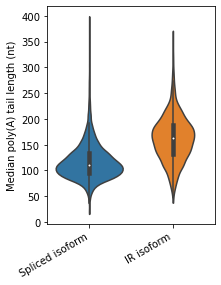

In [148]:
YLIM = 400  # 只画<400polya length的isoform

plt.figure(figsize=(3, 4))
sns.violinplot(
    x='type', y='polya_len', 
    data=isoform_polya_df[isoform_polya_df['polya_len']<=YLIM],
    cut=0
)
plt.ylabel('Median poly(A) tail length (nt)')
plt.xlabel('')
plt.xticks(rotation=30, ha='right')
plt.show()

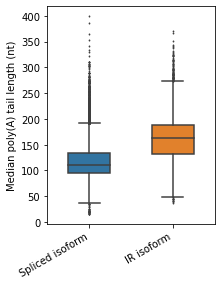

In [149]:
YLIM = 400

plt.figure(figsize=(3, 4))
sns.boxplot(
    x='type', y='polya_len', 
    data=isoform_polya_df[isoform_polya_df['polya_len']<=YLIM],
    fliersize=1,
    width=.5
)
plt.ylabel('Median poly(A) tail length (nt)')
plt.xlabel('')
plt.xticks(rotation=30, ha='right')
plt.show()

📌 **[TODO]** 统计检验，差异是否显著，pvalue

In [150]:
isoform_polya_df.groupby(['type']).describe()

polya_len                                                \
                    count        mean        std        min         25%   
type                                                                      
IR isoform         7316.0  162.024364  44.044219  37.414492  132.665779   
Spliced isoform   23502.0  116.886354  34.348880  15.657158   94.236449   

                                                       count              \
                        50%         75%         max    count        mean   
type                                                                       
IR isoform       162.372154  188.985956  370.953918   7316.0   12.627255   
Spliced isoform  110.996922  132.989733  637.975037  23502.0  120.726576   

                                                            
                        std  min  25%   50%   75%      max  
type                                                        
IR isoform        71.473507  3.0  3.0   5.0   9.0   3575.0  
Spliced isoform  898.917249  3.0  7.0  21.0  64.0  79632.0

In [221]:
data = isoform_polya_df.groupby(['gene_id']).filter(lambda x: len(x)>2)
data = data[data['count'] > 100]
data

,name,gene_id,polya_len,count,type
12,spliced_31,AT1G01050,104.706551,347,Spliced isoform
18,spliced_43,AT1G01080,112.185669,169,Spliced isoform
24,spliced_56,AT1G01100,83.106915,1660,Spliced isoform
81,spliced_161,AT1G01550,116.163971,123,Spliced isoform
89,spliced_182,AT1G01620,85.606468,2505,Spliced isoform
...,...,...,...,...,...
30772,spliced_80263,AT5G67480,117.033890,133,Spliced isoform
30776,spliced_80269,AT5G67500,100.208912,174,Spliced isoform
30787,spliced_80290,AT5G67560,103.509899,174,Spliced isoform
30793,spliced_80311,AT5G67590,87.192451,138,Spliced isoform


In [222]:
test = defaultdict(lambda: {})
for line in data.itertuples():
    if line.type=='Spliced isoform':
        test[line.gene_id]['spliced'] = line.polya_len
    elif line.type=='IR isoform':
        test[line.gene_id]['ir'] = line.polya_len
        
kk = []
for k, v in test.items():
    if len(v) != 2:
        kk.append(k)
for k in kk:
    del test[k]

In [240]:
isoform_polya_df[isoform_polya_df['gene_id'].isin(['AT3G23050'])]

,name,gene_id,polya_len,count,type
15680,spliced_40864,AT3G23050,119.044079,6,Spliced isoform
15681,spliced_40865,AT3G23050,127.758171,5,IR isoform
15682,spliced_40866,AT3G23050,214.552261,103,IR isoform
15683,spliced_40867,AT3G23050,187.590973,3,IR isoform
15684,spliced_40868,AT3G23050,105.266911,1204,Spliced isoform
15685,spliced_40869,AT3G23050,68.599209,10,Spliced isoform
15686,spliced_40870,AT3G23050,42.534607,3,Spliced isoform
15687,spliced_40871,AT3G23050,153.641579,4,IR isoform


# isoform example plot

In [107]:
import sys
sys.path.append('/public/home/mowp/test/nanopore_cdna/script')
import igv

In [ ]:
full_len = '/public/home/mowp/test/nanopore_cdna/full_length_transcripts/fhh.full_length.sorted.bam'
non_full_len = '/public/home/mowp/test/nanopore_cdna/full_length_transcripts/fhh.non_full_length.sorted.bam'
igvplot = igv.IGV('AT1G19000', full_len, non_full_len, plot_polya=True)
igvplot.genomeview()

In [ ]:
for isoform in splice_info.itertuples():
    '''
    Vars:
        @isoform: Pandas(Index='spliced_1', gene_id='AT1G01010', intron_retain=True, exon_skip=False)
        @bed_info: pandas series
    '''
    bed_info = isoform_df.loc[isoform.Index]
    polya_len, polya_count = gat_polya_len(
        bam_path, 
        bed_info.chrom, 
        int(bed_info.chromStart), 
        int(bed_info.chromEnd), 
        bed_info.strand, 
        bed_info.read_id
    )

In [261]:
# AT3G23050

isoforms = ['spliced_40866', 'spliced_40868']
for item in isoforms:
    bed_info = isoform_df.loc[item]
    isoform = splice_info.loc[item]
    polya_len, polya_count, polya_list = gat_polya_len(
        bam_path, 
        bed_info.chrom, 
        int(bed_info.chromStart), 
        int(bed_info.chromEnd), 
        bed_info.strand, 
        bed_info.read_id
    )
    if polya_len is not None:
        if isoform.intron_retain:
            intron_retain_polya = polya_list
        else:
            spliced_polya = polya_list

In [263]:
len(intron_retain_polya)

103

In [259]:
len(spliced_polya)

1204

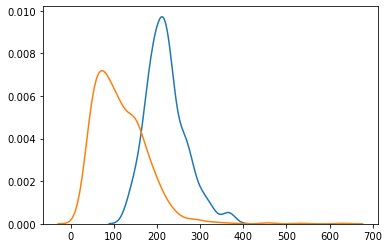

In [265]:
sns.kdeplot(intron_retain_polya)
sns.kdeplot(spliced_polya)

In [279]:
df1 = pd.DataFrame(intron_retain_polya, columns=['polya_len'])
df1['type'] = 'isoform 1'

df2 = pd.DataFrame(spliced_polya, columns=['polya_len'])
df2['type'] = 'isoform 2'

df = pd.concat([df1, df2])
df

,polya_len,type
0,147.942032,isoform 1
1,173.836121,isoform 1
2,228.970123,isoform 1
3,134.346115,isoform 1
4,174.841415,isoform 1
...,...,...
1199,36.802601,isoform 2
1200,115.210808,isoform 2
1201,58.547577,isoform 2
1202,60.952118,isoform 2


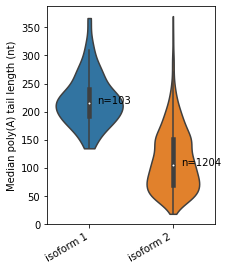

In [313]:
YLIM = 400  # 只画<400polya length的isoform

plt.figure(figsize=(3, 4))
sns.violinplot(
    x='type', y='polya_len', 
    data=df[df['polya_len']<=YLIM],
    cut=0,
)

yposlist = df.groupby(['type'])['polya_len'].median().tolist()
xposlist = np.arange(len(yposlist))+.1
stringlist = [f'n={len(i)}' for i in (intron_retain_polya, spliced_polya)]

plt.ylabel('Median poly(A) tail length (nt)')
plt.xlabel('')
plt.xticks(rotation=30, ha='right')
for i in range(len(stringlist)):
    plt.text(xposlist[i], yposlist[i], stringlist[i])
plt.show()

In [282]:
# Kruskal–Wallis P values
stats.kruskal(intron_retain_polya, spliced_polya)

KruskalResult(statistic=206.07822511701215, pvalue=9.851980720063237e-47)

In [287]:
print(f'intron_retain_polya n={len(intron_retain_polya)}')
print(f'spliced_polya n={len(spliced_polya)}')

intron_retain_polya n=103
spliced_polya n=1204


其他备选基因：

```
AT1G48030
AT2G18050
AT3G53470
AT1G20100
AT3G23050
```